# Inicializacion

## Objetivo del trabajo

Luego de realizado el analisis exploratorio sobre el dataset de enfermedades cardiovasculares, se construira un **modelo de machine learning baseline** sencillo para luego poder compararlo contra mejores modelos.

Se hará utilizando todos los features y un modelo de **regresión logística**.

El objetivo del modelo de ML es predecir si un paciente tiene una enfermedad cardiovascular a partir de las siguientes features:
* Age: edad del paciente [años]

* Sex: sexo del paciente [M: Masculino, F: Femenino]

* ChestPainType: tipo de dolor en el pecho [TA: Angina Típica, ATA: Angina Atípica, NAP: Dolor No Anginoso, ASY: Asintomático]

* RestingBP: presión arterial en reposo [mm Hg]

* Cholesterol: colesterol sérico [mg/dl]

* FastingBS: glucemia en ayunas [1: si FastingBS > 120 mg/dl, 0: en caso contrario]

* RestingECG: resultados del electrocardiograma en reposo [Normal: Normal, ST: anomalía de la onda ST-T (inversiones de la onda T y/o elevación o depresión del ST > 0.05 mV), LVH: posible o definitiva hipertrofia ventricular izquierda según los criterios de Estes]

* MaxHR: frecuencia cardíaca máxima alcanzada [valor numérico entre 60 y 202]

* ExerciseAngina: angina inducida por ejercicio [Y: Sí, N: No]

* Oldpeak: oldpeak = ST [valor numérico medido como depresión del segmento ST]

* ST_Slope: pendiente del segmento ST durante el ejercicio máximo [Up: ascendente, Flat: plana, Down: descendente]

* HeartDisease: clase de salida [1: enfermedad cardíaca, 0: Normal]

## Librerias necesarias

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

## Autenticacion con Google Drive y descarga del archivo

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded_train = drive.CreateFile({'id':"1J901qWCpTLIYVJxWhb7PNuBtgNOc937I"})
downloaded_test = drive.CreateFile({'id': "1gFgeQ4IW7XW0iD3BrC0Mns7jGYjV7rXn"})

downloaded_train.GetContentFile('heart_train.csv')
downloaded_test.GetContentFile('heart_test.csv')

In [ ]:
heart_test = pd.read_csv('heart_test.csv') # Este solo se usara para predecir para la competencia
heart_test.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,46,M,ASY,115,0,0,Normal,113,Y,1.5,Flat
1,58,M,NAP,132,224,0,LVH,173,N,3.2,Up
2,60,M,ASY,125,258,0,LVH,141,Y,2.8,Flat


In [ ]:
heart_data = pd.read_csv('heart_train.csv')
heart_data.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,63,M,ATA,139,217,1,ST,128,Y,1.2,Flat,1
1,55,M,ATA,110,214,1,ST,180,N,0.4,Up,0
2,59,F,ASY,130,338,1,ST,130,Y,1.5,Flat,1


# Regresion Logistica

## Separacion de la variable a predecir

Primero debemos separar el target de las demas variables.

In [ ]:
y = heart_data.HeartDisease
X = heart_data.drop("HeartDisease", axis = 1)

In [ ]:
y

,HeartDisease
0,1
1,0
2,1
3,1
4,1
...,...
729,1
730,0
731,1
732,0


In [ ]:
X

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,63,M,ATA,139,217,1,ST,128,Y,1.2,Flat
1,55,M,ATA,110,214,1,ST,180,N,0.4,Up
2,59,F,ASY,130,338,1,ST,130,Y,1.5,Flat
3,47,M,ASY,160,0,0,Normal,124,Y,0.0,Flat
4,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat
...,...,...,...,...,...,...,...,...,...,...,...
729,51,M,NAP,135,160,0,Normal,150,N,2.0,Flat
730,46,M,NAP,120,230,0,Normal,150,N,0.0,Up
731,59,M,ASY,122,233,0,Normal,117,Y,1.3,Down
732,61,M,ASY,125,292,0,ST,115,Y,0.0,Up


## Separacion entre train y validation

En este caso podemos realizar una separacion aleatoria ya que no tenemos features cronologicas.

Ademas, utilizamos una semilla para poder reproducir los resultados.

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20, random_state=123)
X_test = heart_test # Este se usa para predecir para la competencia

In [ ]:
X_train

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
124,36,M,ATA,120,267,0,Normal,160,N,3.0,Flat
328,56,M,ASY,150,230,0,ST,124,Y,1.5,Flat
708,51,M,ASY,140,261,0,LVH,186,Y,0.0,Up
724,63,M,ASY,130,330,1,LVH,132,Y,1.8,Up
598,51,M,ASY,130,0,1,ST,163,N,0.0,Flat
...,...,...,...,...,...,...,...,...,...,...,...
98,57,M,NAP,150,126,1,Normal,173,N,0.2,Up
322,58,M,NAP,112,230,0,LVH,165,N,2.5,Flat
382,53,M,ATA,120,0,0,Normal,95,N,0.0,Flat
365,54,M,ASY,125,216,0,Normal,140,N,0.0,Flat


In [ ]:
X_validation

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
169,73,F,NAP,160,0,0,ST,121,N,0.0,Up
273,46,M,ASY,134,310,0,Normal,126,N,0.0,Flat
653,66,M,ASY,112,261,0,Normal,140,N,1.5,Up
579,61,F,ATA,140,298,1,Normal,120,Y,0.0,Up
692,59,M,ASY,140,274,0,Normal,154,Y,2.0,Flat
...,...,...,...,...,...,...,...,...,...,...,...
538,61,M,ATA,139,283,0,Normal,135,N,0.3,Up
634,70,M,NAP,160,269,0,Normal,112,Y,2.9,Flat
545,63,M,ASY,150,0,0,Normal,86,Y,2.0,Flat
408,62,M,ASY,120,220,0,ST,86,N,0.0,Up


## Encoding de features categoricas

### Sex

En este caso como la variable 'Sex' solo tiene 2 valores posibles (M o F) podemos utilizar el metodo **One Hot Encoding**, que agrega una columna a nuestro dataset para cada valor posible de la feature.

Ademas, podemos dropear alguno de los valores de la feature (M o F) para que quede solamente una columna booleana y optimizar aun mas el encoding.

In [ ]:
ohe_sex = OneHotEncoder(drop='first') # Dropea uno de los valores de la feature 'Sex'

encoded_sex = ohe_sex.fit_transform(X_train[['Sex']]).toarray().astype(int)
encoded_sex_validation = ohe_sex.transform(X_validation[['Sex']]).toarray().astype(int)
encoded_sex_test = ohe_sex.transform(X_test[['Sex']]).toarray().astype(int)

# fit_transform aprende de los valores presentes en train de la columna Sex
# transform para evitar que posibles valores nuevos de Sex que aparecen en validation se introduzcan para entrenar el modelo

In [ ]:
X_train.Sex = encoded_sex
X_validation.Sex = encoded_sex_validation
X_test.Sex = encoded_sex_test

In [ ]:
X_train.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
124,36,1,ATA,120,267,0,Normal,160,N,3.0,Flat
328,56,1,ASY,150,230,0,ST,124,Y,1.5,Flat
708,51,1,ASY,140,261,0,LVH,186,Y,0.0,Up


### ChestPainType

In [ ]:
X_train.ChestPainType.value_counts()

,count
ChestPainType,
ASY,332
NAP,116
ATA,105
TA,34


Tenemos solo 4 valores posibles, podemos usar OneHotEncoding.

In [ ]:
ohe_cpt = OneHotEncoder(drop='first')

encoded_cpt = ohe_cpt.fit_transform(X_train[['ChestPainType']]).toarray().astype(int)
encoded_cpt_validation = ohe_cpt.transform(X_validation[['ChestPainType']]).toarray().astype(int)
encoded_cpt_test = ohe_cpt.transform(X_test[['ChestPainType']]).toarray().astype(int)

En este caso no podemos simplemente reemplazar los datos de la columna 'ChestPainType' por los codificados, ya que tenemos mas de una columna.

Generamos dos dataframes para unir a los datasets de train y validation, y a cada columna agregada le ponemos el nombre del valor que toma.

In [ ]:
encoded_cpt_df = pd.DataFrame(
    encoded_cpt,
    columns=ohe_cpt.get_feature_names_out(['ChestPainType']),
    index=X_train.index
)

encoded_cpt_validation_df = pd.DataFrame(
    encoded_cpt_validation,
    columns=ohe_cpt.get_feature_names_out(['ChestPainType']),
    index=X_validation.index
)

encoded_cpt_test_df = pd.DataFrame(
    encoded_cpt_test,
    columns=ohe_cpt.get_feature_names_out(['ChestPainType']),
    index=X_test.index
)

In [ ]:
X_train = X_train.drop(columns=['ChestPainType']).join(encoded_cpt_df)
X_validation = X_validation.drop(columns=['ChestPainType']).join(encoded_cpt_validation_df)
X_test = X_test.drop(columns=['ChestPainType']).join(encoded_cpt_test_df)

In [ ]:
X_train

,Age,Sex,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
124,36,1,120,267,0,Normal,160,N,3.0,Flat,1,0,0
328,56,1,150,230,0,ST,124,Y,1.5,Flat,0,0,0
708,51,1,140,261,0,LVH,186,Y,0.0,Up,0,0,0
724,63,1,130,330,1,LVH,132,Y,1.8,Up,0,0,0
598,51,1,130,0,1,ST,163,N,0.0,Flat,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,57,1,150,126,1,Normal,173,N,0.2,Up,0,1,0
322,58,1,112,230,0,LVH,165,N,2.5,Flat,0,1,0
382,53,1,120,0,0,Normal,95,N,0.0,Flat,1,0,0
365,54,1,125,216,0,Normal,140,N,0.0,Flat,0,0,0


### RestingECG

In [ ]:
X_train.RestingECG.value_counts()

,count
RestingECG,
Normal,356
LVH,126
ST,105


Asi como para ChestPainType, tenemos solo 3 valores posibles por lo que hacemos el mismo proceso.

In [ ]:
ohe_recg = OneHotEncoder(drop='first')

encoded_recg = ohe_recg.fit_transform(X_train[['RestingECG']]).toarray().astype(int)
encoded_recg_validation = ohe_recg.transform(X_validation[['RestingECG']]).toarray().astype(int)
encoded_recg_test = ohe_recg.transform(X_test[['RestingECG']]).toarray().astype(int)

In [ ]:
encoded_recg_df = pd.DataFrame(
    encoded_recg,
    columns=ohe_recg.get_feature_names_out(['RestingECG']),
    index=X_train.index
)

encoded_recg_validation_df = pd.DataFrame(
    encoded_recg_validation,
    columns=ohe_recg.get_feature_names_out(['RestingECG']),
    index=X_validation.index
)

encoded_recg_test_df = pd.DataFrame(
    encoded_recg_test,
    columns=ohe_recg.get_feature_names_out(['RestingECG']),
    index=X_test.index
)

In [ ]:
X_train = X_train.drop(columns=['RestingECG']).join(encoded_recg_df)
X_validation = X_validation.drop(columns=['RestingECG']).join(encoded_recg_validation_df)
X_test = X_test.drop(columns=['RestingECG']).join(encoded_recg_test_df)

In [ ]:
X_train.head(3)

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST
124,36,1,120,267,0,160,N,3.0,Flat,1,0,0,1,0
328,56,1,150,230,0,124,Y,1.5,Flat,0,0,0,0,1
708,51,1,140,261,0,186,Y,0.0,Up,0,0,0,0,0


### ExerciseAngina

In [ ]:
X_train.ExerciseAngina.value_counts()

,count
ExerciseAngina,
N,340
Y,247


En este caso, como es una feature booleana podemos realizar el mismo proceso que hicimos con la feature 'Sex'.

In [ ]:
ohe_exa = OneHotEncoder(drop='first')

encoded_exa = ohe_exa.fit_transform(X_train[['ExerciseAngina']]).toarray().astype(int)
encoded_exa_validation = ohe_exa.transform(X_validation[['ExerciseAngina']]).toarray().astype(int)
encoded_exa_test = ohe_exa.transform(X_test[['ExerciseAngina']]).toarray().astype(int)

In [ ]:
X_train.ExerciseAngina = encoded_exa
X_validation.ExerciseAngina = encoded_exa_validation
X_test.ExerciseAngina = encoded_exa_test

In [ ]:
X_train.head(3)

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST
124,36,1,120,267,0,160,0,3.0,Flat,1,0,0,1,0
328,56,1,150,230,0,124,1,1.5,Flat,0,0,0,0,1
708,51,1,140,261,0,186,1,0.0,Up,0,0,0,0,0


### ST_Slope

In [ ]:
X_train.ST_Slope.value_counts()

,count
ST_Slope,
Flat,305
Up,238
Down,44


Nuevamente tenemos 3 valores posibles para 'ST_Slope', por lo que realizamos el mismo proceso que para las features 'RestingECG' y 'ChestPainType'.

In [ ]:
ohe_sts = OneHotEncoder(drop='first')

encoded_sts = ohe_sts.fit_transform(X_train[['ST_Slope']]).toarray().astype(int)
encoded_sts_validation = ohe_sts.transform(X_validation[['ST_Slope']]).toarray().astype(int)
encoded_sts_test = ohe_sts.transform(X_test[['ST_Slope']]).toarray().astype(int)

In [ ]:
encoded_sts_df = pd.DataFrame(
    encoded_sts,
    columns=ohe_sts.get_feature_names_out(['ST_Slope']),
    index=X_train.index
)

encoded_sts_validation_df = pd.DataFrame(
    encoded_sts_validation,
    columns=ohe_sts.get_feature_names_out(['ST_Slope']),
    index=X_validation.index
)

encoded_sts_test_df = pd.DataFrame(
    encoded_sts_test,
    columns=ohe_sts.get_feature_names_out(['ST_Slope']),
    index=X_test.index
)

In [ ]:
X_train = X_train.drop(columns=['ST_Slope']).join(encoded_sts_df)
X_validation = X_validation.drop(columns=['ST_Slope']).join(encoded_sts_validation_df)
X_test = X_test.drop(columns=['ST_Slope']).join(encoded_sts_test_df)

In [ ]:
X_train.head(3)

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
124,36,1,120,267,0,160,0,3.0,1,0,0,1,0,1,0
328,56,1,150,230,0,124,1,1.5,0,0,0,0,1,1,0
708,51,1,140,261,0,186,1,0.0,0,0,0,0,0,0,1


In [ ]:
X_test.head(3)

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,46,1,115,0,0,113,1,1.5,0,0,0,1,0,1,0
1,58,1,132,224,0,173,0,3.2,0,1,0,0,0,0,1
2,60,1,125,258,0,141,1,2.8,0,0,0,0,0,1,0


## Escalado de features

Tenemos features con rangos de valores muy distintos respecto de otros features.
Por ejemplo, los valores de edad van entre 29 y 70 aproximadamente, mientras que los valores de Oldpeak son mucho menores.

Es por esto que debemos escalar los datos para que todos tengan un rango de valores similar y la prediccion sea mejor.

Las features que debemos escalar son:
* Age
* RestingBP
* Cholesterol
* MaxHR
* Oldpeak

### Distribucion de los valores de las features previo al escalado

In [ ]:
import plotly.express as px
columns_to_scale = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
fig = px.histogram(X_train[columns_to_scale],
                   marginal="box",
                   nbins=50,
                   title="Distribución de features - Previo al Escalado",
                   facet_col="variable",
                   facet_col_wrap=3,
                   opacity=0.7)

fig.show()

Vemos que los rangos de valores para cada feature son muy distintos entre si.

### Escalando los datos

Usamos ColumnTransformer de sklearn ya que solo queremos escalar algunas columnas del dataset, no todas.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columns_to_scale),  # Escala estas columnas
        ('passthrough', 'passthrough', [col for col in X_train.columns if col not in columns_to_scale])  # Deja las otras igual
    ]
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_validation_scaled = preprocessor.transform(X_validation)
X_test_scaled = preprocessor.transform(X_test)

ColumnTransformer nos devuelve un array de numpy, por lo que para volverlo a un df debemos hacer algunas modificaciones.

In [ ]:
output_columns = (
    preprocessor.named_transformers_['num'].get_feature_names_out(columns_to_scale).tolist() +
    [col for col in X_train.columns if col not in columns_to_scale]
)

# Convertir a DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=output_columns, index=X_train.index)
X_validation = pd.DataFrame(X_validation_scaled, columns=output_columns, index=X_validation.index)
X_test = pd.DataFrame(X_test_scaled, columns=output_columns, index=X_test.index)

### Distribucion de los valores de las features luego del escalado

In [ ]:
import plotly.express as px
columns_to_scale = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
fig = px.histogram(X_train[columns_to_scale],
                   marginal="box",
                   nbins=50,
                   title="Distribución de features - Previo al Escalado",
                   facet_col="variable",
                   facet_col_wrap=3,
                   opacity=0.7)

fig.show()

Vemos que los rangos de valores de los features escalados estan mucho mas parecidos.

In [ ]:
X_train.head(3)

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex,FastingBS,ExerciseAngina,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
124,-1.905102,-0.706086,0.601409,0.909698,1.964707,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
328,0.241337,0.963602,0.258214,-0.483428,0.554366,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
708,-0.295273,0.407040,0.545756,1.915845,-0.855975,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Prediccion

Por ultimo, haremos la prediccion usando LogisticRegression de sklearn.

In [ ]:
log_reg = LogisticRegression()

In [ ]:
params = [
    {'penalty': ['l1', 'l2', 'elasticnet', None]},
    {'C': [0.0001, 0.001, 0.01, 0.1, 1,]},
    {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}
]

Hacemos la busqueda de hiper-parametros utilizando el alogitmo de RandomSearch, optimizado para la metrica de *accuracy* (cuantas veces nuestro modelo predijo bien).

Los hiper-parametros analizados son:
* penalty: especifica que tipo de penalizacion se aplica para evitar el sobreajuste (tipo de regularizacion)
* C: inversa de la fuerza de regularizacion, controla cuanto vamos a regularizar para evitar el overfitting.
* solver: algoritmo de optimizacion utilizado para obtener los coeficientes.

Las combinaciones de hiper-parametros que no sean compatibles entre si, RandomSearch simplemente les dara un score de 0 (las saltea).

In [ ]:
rs = RandomizedSearchCV(log_reg, param_distributions=params, n_iter=10, random_state=123, scoring='accuracy')

In [ ]:
rs.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(

RandomizedSearchCV(estimator=LogisticRegression(),
                   param_distributions=[{'penalty': ['l1', 'l2', 'elasticnet',
                                                     None]},
                                        {'C': [0.0001, 0.001, 0.01, 0.1, 1]},
                                        {'solver': ['lbfgs', 'liblinear',
                                                    'newton-cg',
                                                    'newton-cholesky', 'sag',
                                                    'saga']}],
                   random_state=123, scoring='accuracy')

In [ ]:
rs.best_params_

{'C': 0.1}

Obtuvimos los hiper-parametros optimos para nuestro modelo.

In [ ]:
model = rs.best_estimator_
model.__dict__

{'penalty': 'l2',
 'dual': False,
 'tol': 0.0001,
 'C': 0.1,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'class_weight': None,
 'random_state': None,
 'solver': 'lbfgs',
 'max_iter': 100,
 'multi_class': 'deprecated',
 'verbose': 0,
 'warm_start': False,
 'n_jobs': None,
 'l1_ratio': None,
 'feature_names_in_': array(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Sex',
        'FastingBS', 'ExerciseAngina', 'ChestPainType_ATA',
        'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_Normal',
        'RestingECG_ST', 'ST_Slope_Flat', 'ST_Slope_Up'], dtype=object),
 'n_features_in_': 15,
 'classes_': array([0, 1]),
 'n_iter_': array([11], dtype=int32),
 'coef_': array([[ 0.01630896, -0.07697014, -0.3464071 , -0.2652376 ,  0.32345399,
          0.63229376,  0.5038574 ,  0.75202065, -0.76895171, -0.81795964,
         -0.37332233, -0.1720665 , -0.13231981,  0.91221638, -1.04110352]]),
 'intercept_': array([-0.04230222])}

Entrenamos nuestro modelo optimo con el set de entrenamiento.

In [ ]:
model.fit(X_train, y_train)

LogisticRegression(C=0.1)

Realizamos las predicciones binarias sobre el set de validacion.

In [ ]:
y_pred = model.predict(X_validation)

## Evaluacion del modelo

### Matriz de Confusion

La matriz de confusion es util para observar que tipos de errores hizo nuestro modelo al predecir.

In [ ]:
y_validation = y_validation.astype(int)

In [ ]:
cm = confusion_matrix(y_validation, y_pred)
cm

array([[66, 17],
       [ 6, 58]])

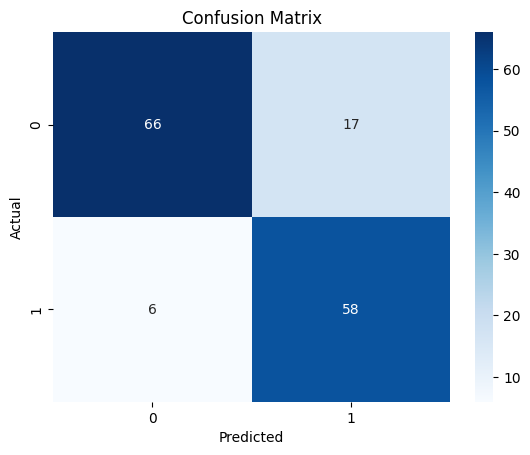

In [ ]:
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Observamos que nuestro modelo hizo 23 predicciones erroneas, y de estas:
* 6 falsos negativos, este es el error que no queremos ya que en nuestro contexto le estariamos diciendo al paciente que no tiene una enfermedad cardiaca cuando si la tiene.
* 17 falsos positivos, en nuestro contexto este error es menos grave, ya que a lo sumo el paciente se lleva un susto de pensar que tiene una enfermedad que en realidad no tiene.

### Accuracy

In [ ]:
y_pred_proba = model.predict_proba(X_validation)[:, 1]

Accuracy en el set de validacion:

In [ ]:
accuracy_score(y_validation, y_pred)

0.8435374149659864

Accuracy en el set de entrenamiento:

In [ ]:
accuracy_score(y_train, model.predict(X_train))

0.8722316865417377

Vemos que el accuracy en el set de entrenamiento no es mucho mayor al del set de validacion, por lo que podemos suponer que nuestro modelo no esta overfitteando demasiado.

### Classification Report

In [ ]:
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.80      0.85        83
           1       0.77      0.91      0.83        64

    accuracy                           0.84       147
   macro avg       0.84      0.85      0.84       147
weighted avg       0.85      0.84      0.84       147



Con el Classification Report podemos ver en mas detalle como se comporto nuestro modelo:
* Metrica de Precision:
  * 92% de las veces que nuestro modelo predijo que un paciente NO tenia enfermedad cardiaca estuvo en lo correcto.
  * 77% de las veces que nuestro modelo predijo que un paciente SI tenia enfermedad cardiaca estuvo en lo correcto.
* Metrica de Recall:
  * De todos los pacientes que NO tenian enfermedad cardiaca, el modelo predijo correctamente el 80%.
  * De todos los pacientes que SI tenian enfermedad cardiaca, el modelo predijo correctamente el 91%.

## Prediccion para la competencia

Con el modelo armado y el set de datos de test ya encodeado y escalado, podemos predecir para la competencia.

In [ ]:
y_pred_test = model.predict(X_test)

In [ ]:
y_pred_test

array([1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1])

Armamos el csv con las predicciones

In [ ]:
y_pred_test = np.array(y_pred_test, dtype=int) # Sino no se escriben en el csv

submission = pd.DataFrame({
    "id": X_test.index,
    "HeartDisease": y_pred_test
})

submission.to_csv("submission.csv", index=False)
submission.head()

,id,HeartDisease
0,0,1
1,1,0
2,2,1
3,3,1
4,4,0


## Preguntas a responder

### ¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el dataset para validar?)

Como vimos, para el score utilizamos la metrica de **accuracy**, que mide que tantas veces acierta nuestro modelo en su prediccion.
El mejor score obtenido para esta metrica fue de **0.84**, un buen score para ser el modelo baseline.

Por otro lado, el dataset para validar lo obtuvimos utilizando la funcion de sklearn *train_test_split*, que divide aleatoriamente al dataset en 2 grupos, train y validation. Se dividio un 80% en train y 20% en validation.

En este caso pudimos dividir al dataset aleatoriamente ya que no tenemos ningun dato cronologico, de lo contrario podriamos haber entrenado a nuestro modelo con informacion futura.

### Al predecir con este modelo para la competencia, ¿Cúal es el score obtenido?

Con el csv generado, se hizo una primera entrega en la competencia. Se obtuvieron los siguientes resultados para la metrica accuracy:
* **private score**: 0.84782
* **public score**: 0.92391

### ¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.

Para obtener la importancia de las features, podemos usar los coeficientes que calculo nuestro modelo para cada uno.
Estos, representan la influencia de cada feature en la prediccion.

Por ejemplo:
* Los coeficientes positivos tienden a influenciar la decision hacia la clase 1.
* Los coeficientes negativos tienden a influenciar la decision hacia la clase 0.

Entonces, podemos calcular la "importancia" de cada feature como el valor absoulto de su coeficiente, ya que cuanto mas grande sea, mayor influenciara en la decision.

In [ ]:
# Obtenemos los coeficientes
coef = model.coef_[0]
coef

array([ 0.01630896, -0.07697014, -0.3464071 , -0.2652376 ,  0.32345399,
        0.63229376,  0.5038574 ,  0.75202065, -0.76895171, -0.81795964,
       -0.37332233, -0.1720665 , -0.13231981,  0.91221638, -1.04110352])

In [ ]:
abs_coef = np.abs(coef)
abs_coef

array([0.01630896, 0.07697014, 0.3464071 , 0.2652376 , 0.32345399,
       0.63229376, 0.5038574 , 0.75202065, 0.76895171, 0.81795964,
       0.37332233, 0.1720665 , 0.13231981, 0.91221638, 1.04110352])

In [ ]:
features = X_train.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'AbsImportance': abs_coef
})

importance_df = importance_df.sort_values(by='AbsImportance', ascending=True)
importance_df.head()

,Feature,AbsImportance
0,Age,0.016309
1,RestingBP,0.076970
12,RestingECG_ST,0.132320
11,RestingECG_Normal,0.172067
3,MaxHR,0.265238


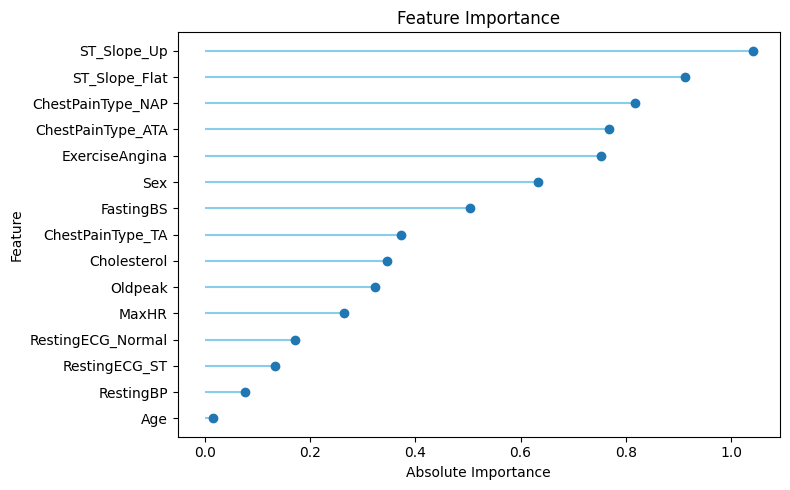

In [ ]:
y_pos = np.arange(len(importance_df))

plt.figure(figsize=(8, 5))
plt.hlines(y=y_pos, xmin=0, xmax=importance_df['AbsImportance'], color='skyblue')
plt.plot(importance_df['AbsImportance'], y_pos, "o")

plt.yticks(y_pos, importance_df['Feature'])
plt.title("Feature Importance", loc='center')
plt.xlabel('Absolute Importance')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

Vemos que las features que nuestro modelo considero mas influyentes en la prediccion son:
* **ST_Slope**: Ambos valores posibles (y el valor faltante tambien) son los 2 features con coeficiente absoluto mas alto.
* **ChestPainType**: Ambos valores posibles (y el valor faltante tambien) tambien tienen un coeficiente absoluto alto.
* **ExerciseAngina** y **Sex**: Tambien tuvieron coeficientes absolutos altos.